# Mosaic Transform Example

This notebook demonstrates the `Mosaic` augmentation from Albumentations.

`Mosaic` combines multiple images and their corresponding annotations (masks, bounding boxes, keypoints) into a single larger image, arranging them in a grid.

**Key Features Illustrated:**

1.  **Combining Multiple Inputs:** Shows how `Mosaic` uses a primary image and additional images provided via metadata.
2.  **Handling Annotations:** Demonstrates the transformation of masks, bounding boxes, and keypoints alongside the images.
3.  **Label Handling:** Explains how labels for bounding boxes and keypoints are managed, especially when combining items with potentially different label sets.
4.  **Geometric Adjustments:** Illustrates how images/annotations are cropped, resized, and placed onto the final mosaic canvas.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


# Helper functions for visualization
def visualize_image_mask(image, mask, title="Image and Mask"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    image = image.copy()
    mask = mask.copy()
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[0].axis("off")
    # Ensure mask is 2D for grayscale display
    if mask.ndim == 3 and mask.shape[2] == 1:
        mask_display = mask[:, :, 0]
    else:
        mask_display = mask
    ax[1].imshow(mask_display, cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


def visualize_bbox(img, bboxes, labels=None, title="Image with Bounding Boxes"):
    img_copy = img.copy()
    # Convert to RGB for display if in BGR

    # Use a colormap for different classes
    unique_labels = list(set(labels)) if labels else []
    colors = plt.cm.viridis(np.linspace(0, 1, max(len(unique_labels), 1)))

    for i, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max = map(int, bbox[:4])

        # Get color based on label
        if labels is not None and i < len(labels):
            label_text = str(labels[i])
            # Find index of this label in unique_labels
            color_idx = unique_labels.index(label_text) if label_text in unique_labels else 0
            color = tuple(int(c * 255) for c in colors[color_idx][:3])  # RGBA to BGR
        else:
            label_text = ""
            color = (0, 255, 0)  # Default green

        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, 2)

        if label_text:
            cv2.putText(img_copy, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_copy)
    plt.title(title)
    plt.axis("off")
    plt.show()


def visualize_keypoints(img, keypoints, labels=None, title="Image with Keypoints"):
    img_copy = img.copy()

    # Use a colormap for different keypoint labels
    unique_labels = list(set(labels)) if labels else []
    colors = plt.cm.viridis(np.linspace(0, 1, max(len(unique_labels), 1)))

    for i, kp in enumerate(keypoints):
        x, y = map(int, kp[:2])

        # Get color based on label
        if labels is not None and i < len(labels):
            label_text = str(labels[i])
            # Find index of this label in unique_labels
            color_idx = unique_labels.index(label_text) if label_text in unique_labels else 0
            color = tuple(int(c * 255) for c in colors[color_idx][:3])  # RGBA to BGR
        else:
            label_text = ""
            color = (0, 0, 255)  # Default red

        # Draw circle for keypoint
        cv2.circle(img_copy, (x, y), 5, color, -1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_copy)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
import json
import os

import albumentations as A


# Function to parse LabelMe JSON format
def parse_labelme_json(json_path):
    """Parse LabelMe JSON annotations to extract bounding boxes, masks, and keypoints."""
    with open(json_path) as f:
        data = json.load(f)

    image_path = os.path.join(os.path.dirname(json_path), data["imagePath"])
    # Read as RGB directly

    image = cv2.imread(image_path, cv2.IMREAD_COLOR_RGB)

    height, width = image.shape[:2]

    # Initialize outputs
    bboxes = []
    keypoints = []
    mask = np.zeros((height, width), dtype=np.uint8)
    bbox_labels = []
    keypoint_labels = []

    for shape in data["shapes"]:
        label = shape["label"]
        shape_type = shape["shape_type"]
        points = np.array(shape["points"])

        if shape_type == "rectangle":
            # Rectangle is specified by two points: top-left and bottom-right
            x_min, y_min = points[0]
            x_max, y_max = points[1]

            # Add to bboxes in [x_min, y_min, x_max, y_max] format
            bboxes.append([x_min, y_min, x_max, y_max])
            bbox_labels.append(label)

        elif shape_type == "polygon":
            # Convert polygon to mask - don't add as a bounding box
            points = points.astype(np.int32)
            cv2.fillPoly(mask, [points], 255)  # Fill with 255 (white)

        elif shape_type == "point":
            # Handle keypoints
            x, y = points[0]
            keypoints.append([x, y, 2])  # 2 means visible keypoint
            keypoint_labels.append(label)

    # Convert to format expected by albumentations
    if bboxes:
        bboxes = np.array(bboxes, dtype=np.float32)
    else:
        bboxes = np.zeros((0, 4), dtype=np.float32)

    if keypoints:
        keypoints = np.array(keypoints, dtype=np.float32)
    else:
        keypoints = np.zeros((0, 3), dtype=np.float32)

    return {
        "image": image,
        "bboxes": bboxes,
        "keypoints": keypoints,
        "mask": mask,
        "bbox_labels": bbox_labels,
        "keypoint_labels": keypoint_labels,
        "image_path": image_path,
    }


# Visualization helper function
def visualize(image, bboxes=None, keypoints=None, mask=None, bbox_labels=None, keypoint_labels=None):
    """Visualize an image with its bounding boxes, keypoints, and masks."""
    plt.figure(figsize=(12, 10))
    plt.imshow(image)

    if mask is not None and np.any(mask):
        # Display mask as a semi-transparent overlay
        mask_img = np.zeros_like(image)
        mask_img[:, :, 0] = mask  # Set red channel
        plt.imshow(mask_img, alpha=0.3)

    if bboxes is not None and len(bboxes) > 0:
        for i, bbox in enumerate(bboxes):
            x_min, y_min, x_max, y_max = bbox
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor="red", linewidth=2)
            plt.gca().add_patch(rect)

            # Add label if available
            if bbox_labels is not None and i < len(bbox_labels):
                plt.text(x_min, y_min - 5, bbox_labels[i], color="red", fontsize=12, backgroundcolor="white")

    if keypoints is not None and len(keypoints) > 0:
        for i, kp in enumerate(keypoints):
            x, y, v = kp
            if v > 0:  # if keypoint is visible
                plt.scatter(x, y, s=50, c="blue", marker="o")

    plt.axis("off")
    plt.tight_layout()
    plt.show()

Loading and visualizing the first few images...
['billy.json', 'skull.json', 'road.json', 'spectrogram.json', 'driving.json']
Visualizing billy.json...


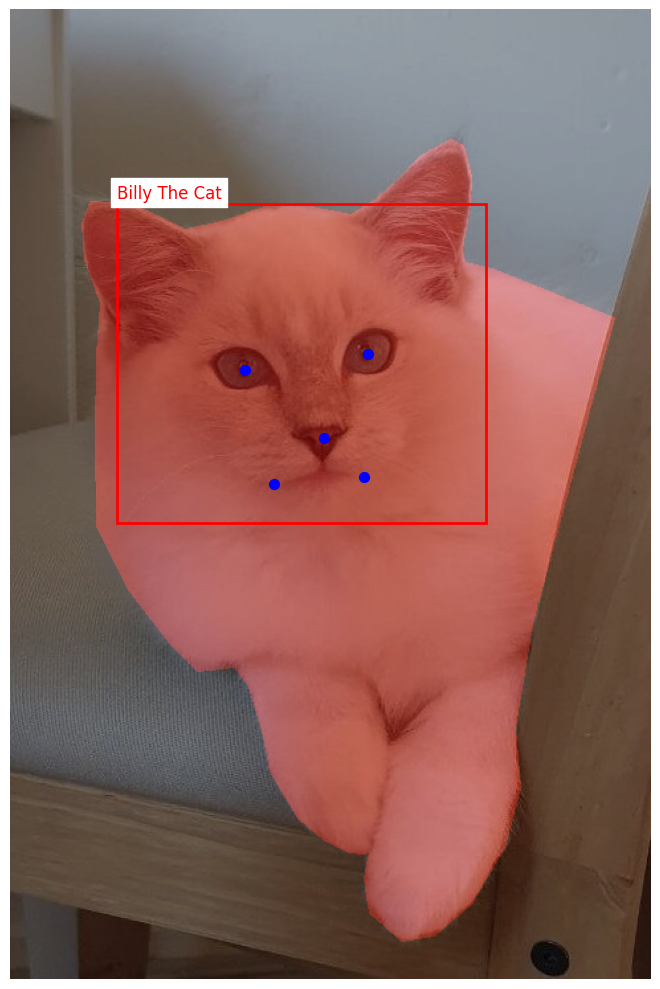

Found 1 bounding boxes and 5 keypoints
--------------------------------------------------
Visualizing skull.json...


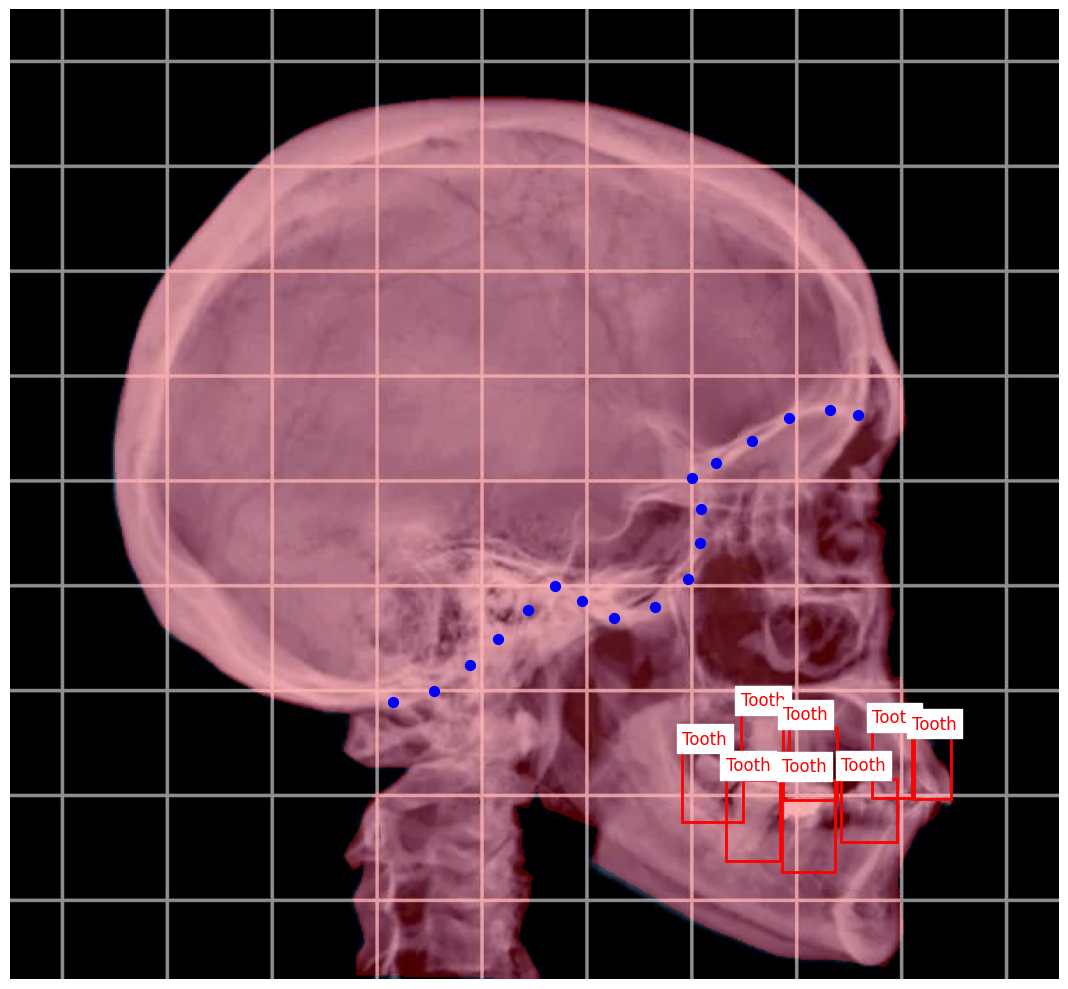

Found 8 bounding boxes and 18 keypoints
--------------------------------------------------
Visualizing road.json...


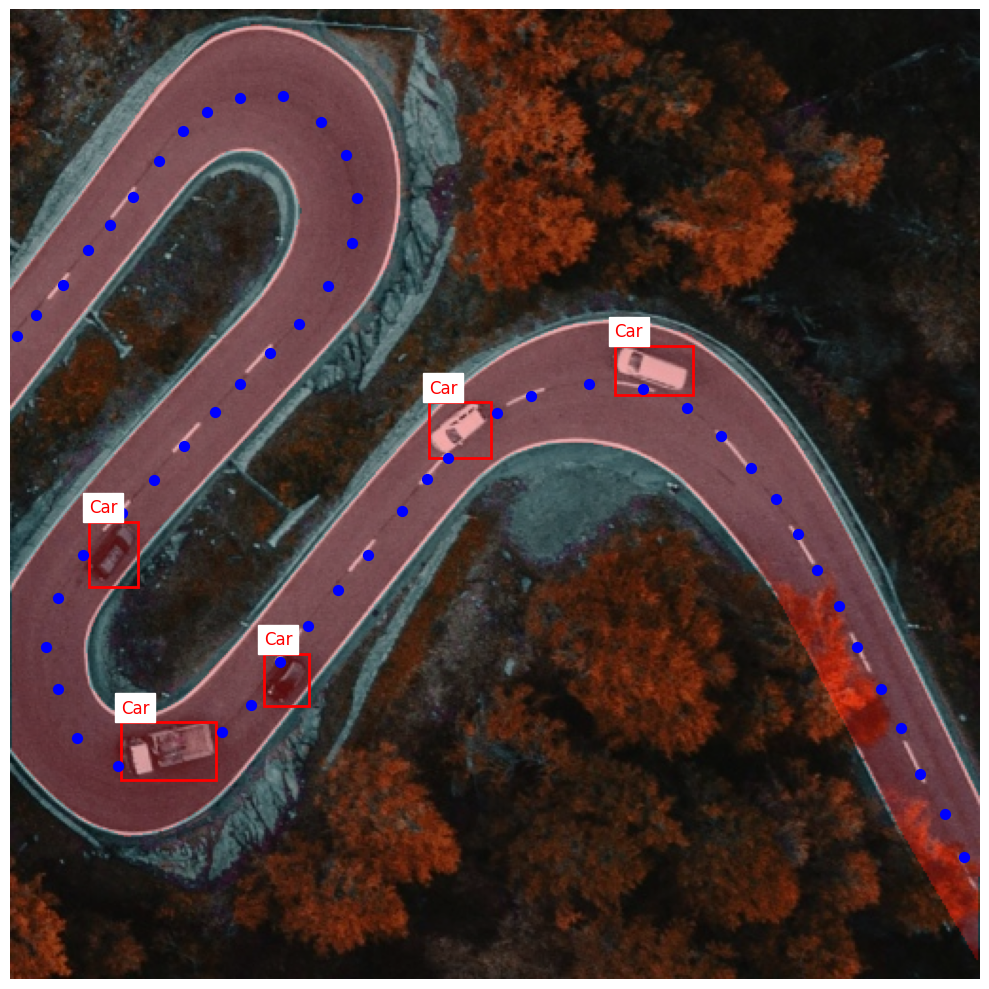

Found 5 bounding boxes and 55 keypoints
--------------------------------------------------
Visualizing spectrogram.json...


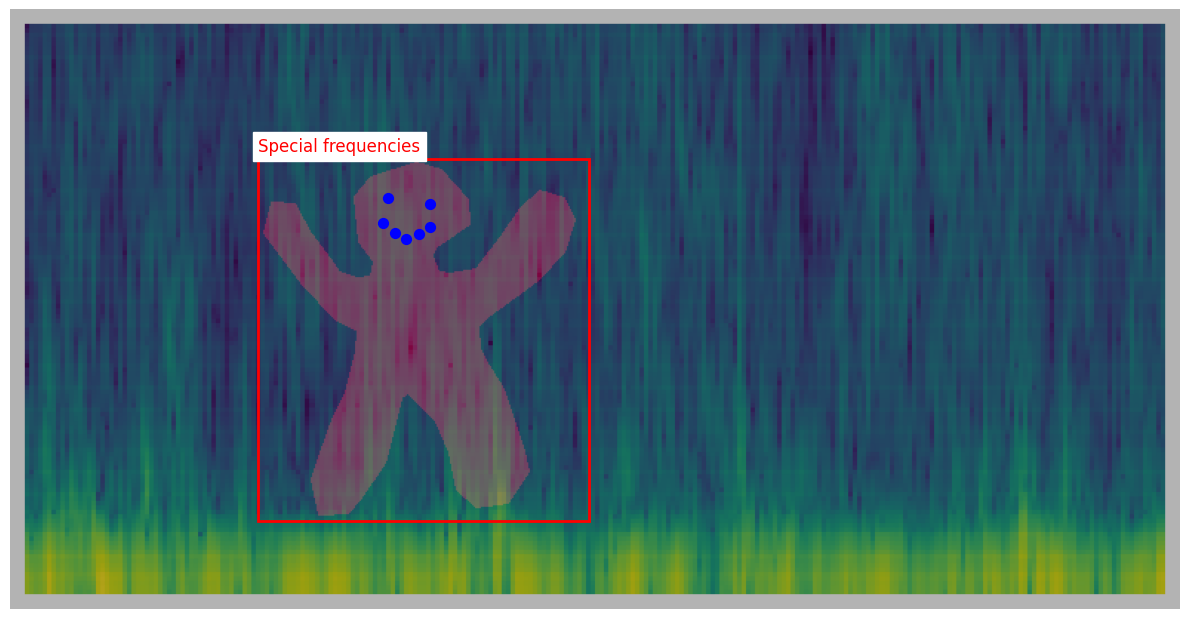

Found 1 bounding boxes and 7 keypoints
--------------------------------------------------
Visualizing driving.json...


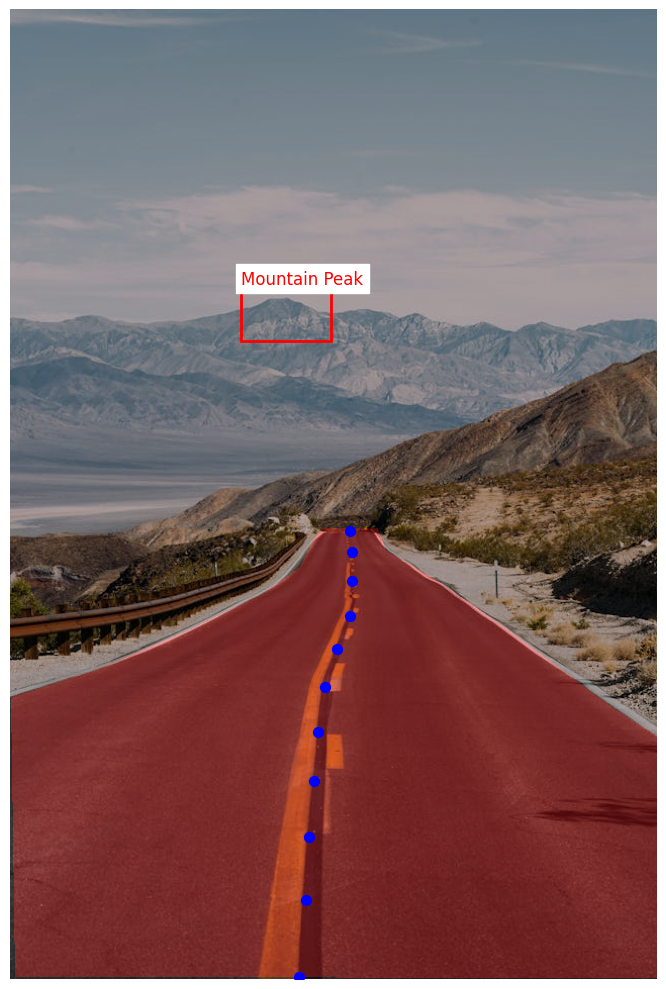

Found 1 bounding boxes and 11 keypoints
--------------------------------------------------


In [ ]:
# Load example data
print("Loading and visualizing the first few images...")
image_dir = "images/mosaic"  # Changed from notebooks/images/mosaic
json_files = [f for f in os.listdir(image_dir) if f.endswith(".json")]

print(json_files)

examples = []
for json_file in json_files:  # Load first three as examples
    json_path = os.path.join(image_dir, json_file)
    example = parse_labelme_json(json_path)
    examples.append(example)

    print(f"Visualizing {json_file}...")
    visualize(
        example["image"],
        example["bboxes"],
        example["keypoints"],
        example["mask"],
        example["bbox_labels"],
        example["keypoint_labels"],
    )

    print(f"Found {len(example['bboxes'])} bounding boxes and {len(example['keypoints'])} keypoints")
    print("-" * 50)

5


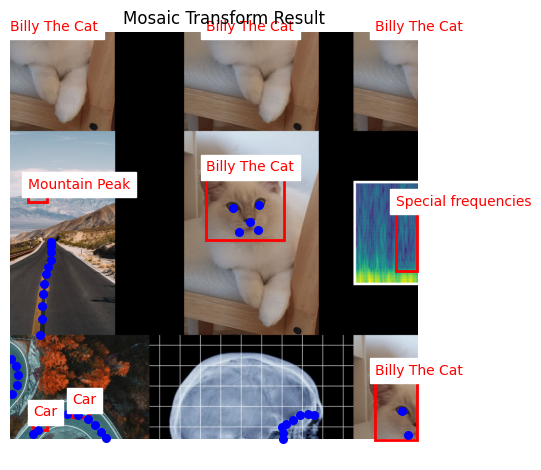

After Mosaic: 9 bounding boxes and 41 keypoints


In [ ]:
# Now let's define the Mosaic transform and apply it
def get_mosaic_transform(grid_yx=(3, 3), target_size=(1024, 1024)):
    """Define a Mosaic transform."""
    transform = A.Compose(
        [
            A.Mosaic(
                grid_yx=grid_yx,
                cell_shape=(512, 512),
                fit_mode="contain",
                target_size=target_size,
                metadata_key="mosaic_metadata",
                p=1,
            ),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["bbox_labels"]),
        keypoint_params=A.KeypointParams(format="xy", label_fields=["keypoint_labels"]),
        p=1,
    )
    return transform


# Prepare the input dictionary for the transform pipeline
# Extract the primary image and its annotations
primary_example = examples[0]
primary_data = {
    "image": primary_example["image"],
    "bboxes": primary_example["bboxes"],
    "keypoints": primary_example["keypoints"],
    "mask": primary_example["mask"],
    "bbox_labels": primary_example["bbox_labels"],
    "keypoint_labels": primary_example["keypoint_labels"],
    # Provide additional images as metadata for the Mosaic transform
    "mosaic_metadata": examples[1:],
}

print(len(examples))

# Apply the transform
mosaic_transform = get_mosaic_transform()
result = mosaic_transform(**primary_data)

# Visualize the result
# plt.figure(figsize=(14, 12))
plt.imshow(result["image"])

# Draw bounding boxes
for i, bbox in enumerate(result["bboxes"]):
    x_min, y_min, x_max, y_max = bbox[0], bbox[1], bbox[2], bbox[3]
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor="red", linewidth=2)
    plt.gca().add_patch(rect)

    # Add label if available
    if "bbox_labels" in result and i < len(result["bbox_labels"]):
        plt.text(x_min, y_min - 5, result["bbox_labels"][i], color="red", fontsize=10, backgroundcolor="white")

# Draw keypoints
if "keypoints" in result and len(result["keypoints"]) > 0:
    for i, kp in enumerate(result["keypoints"]):
        x, y = kp[0], kp[1]
        plt.scatter(x, y, s=30, c="blue", marker="o")


plt.title("Mosaic Transform Result")
plt.axis("off")
plt.tight_layout()
plt.show()

print(f"After Mosaic: {len(result['bboxes'])} bounding boxes and {len(result['keypoints'])} keypoints")